## 라이브러리 로딩

In [1]:
# 기본 라이브러리 로딩
import pandas as pd
import numpy as np
import re # 정규표현식

# 토픽 모델링 관련 라이브러리 로딩
import gensim 
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel

# 시각화 라이브러리
from pprint import pprint
import pyLDAvis
from pyLDAvis import gensim
import matplotlib.pyplot as plt
%matplotlib inline

# 토크나이징 라이브러리
from konlpy.tag import Twitter,Komoran,Kkma
twitter = Twitter()
komoran = Komoran()
kkma = Kkma()

#기타 라이브러리
import time
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\func_inspect.py:53: DeprecationWarning: invalid escape sequence \<
  '\<doctest (.*\.rst)\[(.*)\]\>', source_file).groups()
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\_memory_helpers.py:10: DeprecationWarning: invalid escape sequence \s
  cookie_re = re.compile("coding[:=]\s*([-\w.]+)")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:349: DeprecationWarning: invalid escape sequence \k
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:578: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:972: DeprecationWarning: invalid escape sequence \s
  """
C:\Progr

## 데이터 불러오기

In [184]:
df=pd.read_csv('1202dataset.csv',engine='python')
df.head()

,genre,rank,name,review
0,전략,17,Rebuild 3: Gangs of Deadsville,시간 가는 줄 모르고 하게 되네요 어느 정도 알고나면 단조로운 감이 조금 있지만 충...
1,전략,17,Rebuild 3: Gangs of Deadsville,지금 기준으로 인생 최고의 게임이다. 하지만 다운로드 수 500만 이상 될 줄 알았...
2,전략,17,Rebuild 3: Gangs of Deadsville,너무 재미있는 게임이네요 시간가는 줄 모르고 플레이하다가 밤까지 새는 게임.
3,전략,17,Rebuild 3: Gangs of Deadsville,한글 어떻게 하나요 불편해요.
4,전략,17,Rebuild 3: Gangs of Deadsville,드디어 엔딩 봐서 뿌듯해요.


In [186]:
len(df.name.unique())

244

## 장르별 3천개씩 샘플링 후 merge

In [12]:
a = df.loc[df['genre']=='전략',:]
b = df.loc[df['genre']=='퍼즐',:]
c = df.loc[df['genre']=='액션',:]
d = df.loc[df['genre']=='어드벤처',:]
e = df.loc[df['genre']=='롤플레잉',:]
f = df.loc[df['genre']=='시뮬레이션',:]
rows = np.random.choice(a.index.values, 3000)
a = a.ix[rows] 
rows = np.random.choice(b.index.values, 3000)
b = b.ix[rows] 
rows = np.random.choice(c.index.values, 3000)
c = c.ix[rows] 
rows = np.random.choice(d.index.values, 3000)
d = d.ix[rows] 
rows = np.random.choice(e.index.values, 3000)
e = e.ix[rows] 
rows = np.random.choice(f.index.values, 3000)
f = f.ix[rows]
set1=pd.concat([a,b])
set2=pd.concat([set1,c])
set3=pd.concat([set2,d])
set4=pd.concat([set3,e])
set5=pd.concat([set4,f])

## 데이터 품사 태깅

In [187]:
data=df
data.shape

(47933, 4)

In [188]:
tokens_check = []

for i in list(data["review"]):
    k = komoran.pos(i)
    tokens_check.append(k)

print(tokens_check[:10])

# 품사 태깅 - kkma

tokens_all = []

for i in list(data["review"]):
    k = komoran.morphs(i)
    
    tokens = []
    
    for j in range(len(k)):
        if len(k[j]) > 1:
            tokens.append(k[j])
        else:
            continue
    tokens_all.append(tokens)
    
print(tokens_all[:10])
tokens_df = pd.DataFrame({"tokens":tokens_all})

data["tokens_contents"] = tokens_all
data["tokens_contents_check"] = tokens_check

[[('시간', 'NNG'), ('가', 'VV'), ('는', 'ETM'), ('주', 'VX'), ('ㄹ', 'ETM'), ('모르', 'VV'), ('고', 'EC'), ('하', 'VV'), ('게', 'EC'), ('되', 'VV'), ('네요', 'EC'), ('어느', 'MM'), ('정도', 'NNG'), ('알', 'VV'), ('고', 'EC'), ('나', 'VX'), ('면', 'EC'), ('단조롭', 'VA'), ('ㄴ', 'ETM'), ('감', 'NNG'), ('이', 'JKS'), ('조금', 'MAG'), ('있', 'VV'), ('지만', 'EC'), ('충분히', 'MAG'), ('재밌', 'VA'), ('습니다', 'EF'), ('.', 'SF')], [('지금', 'MAG'), ('기준', 'NNG'), ('으로', 'JKB'), ('인생', 'NNG'), ('최고', 'NNG'), ('의', 'JKG'), ('게임', 'NNG'), ('이', 'VCP'), ('다', 'EF'), ('.', 'SF'), ('하지만', 'MAJ'), ('다운로드', 'NNP'), ('수', 'NNB'), ('500', 'SN'), ('만', 'NR'), ('이상', 'NNG'), ('되', 'VV'), ('ㄹ', 'ETM'), ('주', 'VX'), ('ㄹ', 'ETM'), ('알', 'VV'), ('았', 'EP'), ('는데', 'EC'), ('의외로', 'MAG'), ('적', 'VA'), ('다', 'EF'), ('.', 'SF')], [('너무', 'MAG'), ('재미있', 'VA'), ('는', 'ETM'), ('게임', 'NNG'), ('이', 'VCP'), ('네요', 'EC'), ('시간', 'NNG'), ('가', 'VV'), ('는', 'ETM'), ('주', 'VX'), ('ㄹ', 'ETM'), ('모르', 'VV'), ('고', 'EC'), ('플레이', 'NNG'), ('하', 'XSV'), ('다가', 'EC'

In [11]:
data.head()

,genre,rank,name,review,tokens_contents,tokens_contents_check
0,전략,17,Rebuild 3: Gangs of Deadsville,시간 가는 줄 모르고 하게 되네요 어느 정도 알고나면 단조로운 감이 조금 있지만 충...,"[시간, 모르, 네요, 어느, 정도, 단조롭, 조금, 지만, 충분히, 재밌, 습니다]","[(시간, NNG), (가, VV), (는, ETM), (주, VX), (ㄹ, ET..."
1,전략,17,Rebuild 3: Gangs of Deadsville,지금 기준으로 인생 최고의 게임이다. 하지만 다운로드 수 500만 이상 될 줄 알았...,"[지금, 기준, 으로, 인생, 최고, 게임, 하지만, 다운로드, 500, 이상, 는...","[(지금, MAG), (기준, NNG), (으로, JKB), (인생, NNG), (..."
2,전략,17,Rebuild 3: Gangs of Deadsville,너무 재미있는 게임이네요 시간가는 줄 모르고 플레이하다가 밤까지 새는 게임.,"[너무, 재미있, 게임, 네요, 시간, 모르, 플레이, 다가, 까지, 게임]","[(너무, MAG), (재미있, VA), (는, ETM), (게임, NNG), (이..."
3,전략,17,Rebuild 3: Gangs of Deadsville,한글 어떻게 하나요 불편해요.,"[한글, 어떻, 나요, 불편, 아요]","[(한글, NNP), (어떻, VA), (게, EC), (하, VV), (나요, E..."
4,전략,17,Rebuild 3: Gangs of Deadsville,드디어 엔딩 봐서 뿌듯해요.,"[드디어, 아서, 뿌듯, 어요]","[(드디어, MAG), (엔, NNG), (딩, MAG), (보, VV), (아서,..."


In [13]:
data23000.to_csv('data23000.csv',mode='w',encoding='cp949')

In [9]:
edu1=pd.read_csv('data18000.csv',encoding='cp949')
edu1.head()

,Unnamed: 0,genre,rank,name,review,tokens_contents,tokens_contents_check
0,0,전략,17,Rebuild 3: Gangs of Deadsville,시간 가는 줄 모르고 하게 되네요 어느 정도 알고나면 단조로운 감이 조금 있지만 충...,"['시간', '모르', '네요', '어느', '정도', '단조', '조금', '지만...","[('시간', 'NNG'), ('갈', 'VV'), ('는', 'ETD'), ('줄..."
1,1,전략,17,Rebuild 3: Gangs of Deadsville,지금 기준으로 인생 최고의 게임이다. 하지만 다운로드 수 500만 이상 될 줄 알았...,"['지금', '기준', '으로', '인생', '최고', '게임', '하지만', '다...","[('지금', 'NNG'), ('기준', 'NNG'), ('으로', 'JKM'), ..."
2,2,전략,17,Rebuild 3: Gangs of Deadsville,너무 재미있는 게임이네요 시간가는 줄 모르고 플레이하다가 밤까지 새는 게임.,"['너무', '재미있', '게임', '네요', '시간', '모르', '플레이', '...","[('너무', 'MAG'), ('재미있', 'VA'), ('는', 'ETD'), (..."
3,3,전략,17,Rebuild 3: Gangs of Deadsville,한글 어떻게 하나요 불편해요.,"['한글', '어떻게', '하나', '불편', '어요']","[('한글', 'NNG'), ('어떻게', 'MAG'), ('하나', 'NNG'),..."
4,4,전략,17,Rebuild 3: Gangs of Deadsville,드디어 엔딩 봐서 뿌듯해요.,"['드디어', '엔딩', '아서', '뿌듯', '어요']","[('드디어', 'MAG'), ('엔딩', 'NNG'), ('보', 'VV'), (..."


In [189]:
edu1=data

In [190]:
def tuple_to_list(x):
    d=[]
    for i in x:
        d.append(list(i))
    d1=sum(d,[])
    return d1
edu1['tokens_contents_check_sum']=edu1['tokens_contents_check'].apply(lambda x: tuple_to_list(x))
edu1['tokens_contents_check_sum']

0        [시간, NNG, 가, VV, 는, ETM, 주, VX, ㄹ, ETM, 모르, VV...
1        [지금, MAG, 기준, NNG, 으로, JKB, 인생, NNG, 최고, NNG, ...
2        [너무, MAG, 재미있, VA, 는, ETM, 게임, NNG, 이, VCP, 네요...
3        [한글, NNP, 어떻, VA, 게, EC, 하, VV, 나요, EC, 불편, NN...
4        [드디어, MAG, 엔, NNG, 딩, MAG, 보, VV, 아서, EC, 뿌듯, ...
5        [한글판, NNG, 을, JKO, 원하, VV, 시, EP, 는, ETM, 분, N...
6        [돈, NNG, 이, JKS, 아깝, VA, 지, EC, 않, VX, 아요, EF,...
7        [게임, NNG, 성, XSN, 은, JX, 값어치, NNG, 이상, NNG, 으로...
8                                   [좋, VA, 아요, EF, ., SF]
9        [영어, NNP, 의, JKG, 압박, NNG, 만, JX, 이기, VV, 어, E...
10       [진정, XR, 하, XSA, ㄴ, ETM, 워킹, NNP, 데드, NNG, 게임,...
11       [이지, NNP, 모드, NNP, 로, JKB, 하, VV, 면, EC, 좀, MA...
12       [채, VV, 업, VV, 트, VV, 어, EC, 가, JKS, 짧, VA, 습니...
13       [진짜, MAG, 다, MAG, 너무너무, MAG, 좋, VA, 은데, EC, 구글...
14       [게임, NNG, 도, JX, 좋, VA, 고, EC, 재미있, VA, 는데, EC...
15       [팬, NNG, 으로, JKB, 아주, MAG, 강력, XR, 하, XSA, 게, ...
16       [진짜, MAG, 멋지, VA, ㄴ, ETM, 게임, NNG, 이, VCP, ㅂ니다.

In [191]:
def tidy_split(df, column, sep='|',keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df

In [192]:
h=tidy_split(edu1,'tokens_contents_check_sum','EFN')
h1=tidy_split(h,'tokens_contents_check_sum','EFQ')
h2=tidy_split(h1,'tokens_contents_check_sum','EFO')
h3=tidy_split(h2,'tokens_contents_check_sum','EFA')
h4=tidy_split(h3,'tokens_contents_check_sum','EFN')
h5=tidy_split(h4,'tokens_contents_check_sum','EFI')
h6=tidy_split(h5,'tokens_contents_check_sum','EFR')

h7=tidy_split(h6,'tokens_contents_check_sum','ECE')
h8=tidy_split(h7,'tokens_contents_check_sum','ECD')
h9=tidy_split(h8,'tokens_contents_check_sum','ECS')


h12=tidy_split(h9,'tokens_contents_check_sum','MAC')
h12.head()







,genre,rank,name,review,tokens_contents,tokens_contents_check,tokens_contents_check_sum
0,전략,17,Rebuild 3: Gangs of Deadsville,시간 가는 줄 모르고 하게 되네요 어느 정도 알고나면 단조로운 감이 조금 있지만 충...,"[시간, 모르, 네요, 어느, 정도, 단조롭, 조금, 지만, 충분히, 재밌, 습니다]","[(시간, NNG), (가, VV), (는, ETM), (주, VX), (ㄹ, ET...","['시간', 'NNG', '가', 'VV', '는', 'ETM', '주', 'VX'..."
1,전략,17,Rebuild 3: Gangs of Deadsville,지금 기준으로 인생 최고의 게임이다. 하지만 다운로드 수 500만 이상 될 줄 알았...,"[지금, 기준, 으로, 인생, 최고, 게임, 하지만, 다운로드, 500, 이상, 는...","[(지금, MAG), (기준, NNG), (으로, JKB), (인생, NNG), (...","['지금', 'MAG', '기준', 'NNG', '으로', 'JKB', '인생', ..."
2,전략,17,Rebuild 3: Gangs of Deadsville,너무 재미있는 게임이네요 시간가는 줄 모르고 플레이하다가 밤까지 새는 게임.,"[너무, 재미있, 게임, 네요, 시간, 모르, 플레이, 다가, 까지, 게임]","[(너무, MAG), (재미있, VA), (는, ETM), (게임, NNG), (이...","['너무', 'MAG', '재미있', 'VA', '는', 'ETM', '게임', '..."
3,전략,17,Rebuild 3: Gangs of Deadsville,한글 어떻게 하나요 불편해요.,"[한글, 어떻, 나요, 불편, 아요]","[(한글, NNP), (어떻, VA), (게, EC), (하, VV), (나요, E...","['한글', 'NNP', '어떻', 'VA', '게', 'EC', '하', 'VV'..."
4,전략,17,Rebuild 3: Gangs of Deadsville,드디어 엔딩 봐서 뿌듯해요.,"[드디어, 아서, 뿌듯, 어요]","[(드디어, MAG), (엔, NNG), (딩, MAG), (보, VV), (아서,...","['드디어', 'MAG', '엔', 'NNG', '딩', 'MAG', '보', 'V..."


In [193]:
h12['tokens_contents_check_sum']=h12['tokens_contents_check_sum'].apply(lambda x : x.replace("[",""))
h12['tokens_contents_check_sum']=h12['tokens_contents_check_sum'].apply(lambda x : x.replace("]",""))
h12['tokens_contents_check_sum']=h12['tokens_contents_check_sum'].apply(lambda x : x.replace("'",""))
h12['tokens_contents_check_sum']=h12['tokens_contents_check_sum'].apply(lambda x : x.replace(" ",""))
#h12['tokens_contents_check_sum']=h12['tokens_contents_check_sum'].apply(lambda x : x.split(","))

In [194]:
h12['tokens_contents_check_sum']=h12['tokens_contents_check_sum'].apply(lambda x : x.replace(","," "))
import re
hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
h12['tokens_contents_check_sum']=h12['tokens_contents_check_sum'].apply(lambda x : hangul.sub("",x))


In [22]:
h12.head()

,genre,rank,name,review,tokens_contents,tokens_contents_check,tokens_contents_check_sum
0,전략,17,Rebuild 3: Gangs of Deadsville,시간 가는 줄 모르고 하게 되네요 어느 정도 알고나면 단조로운 감이 조금 있지만 충...,"[시간, 모르, 네요, 어느, 정도, 단조, 조금, 지만, 충분히, 재밌, 습니다]","[(시간, NNG), (갈, VV), (는, ETD), (줄, NNB), (모르, ...",시간 갈 는 줄 모르 고
0,전략,17,Rebuild 3: Gangs of Deadsville,시간 가는 줄 모르고 하게 되네요 어느 정도 알고나면 단조로운 감이 조금 있지만 충...,"[시간, 모르, 네요, 어느, 정도, 단조, 조금, 지만, 충분히, 재밌, 습니다]","[(시간, NNG), (갈, VV), (는, ETD), (줄, NNB), (모르, ...",하 게
0,전략,17,Rebuild 3: Gangs of Deadsville,시간 가는 줄 모르고 하게 되네요 어느 정도 알고나면 단조로운 감이 조금 있지만 충...,"[시간, 모르, 네요, 어느, 정도, 단조, 조금, 지만, 충분히, 재밌, 습니다]","[(시간, NNG), (갈, VV), (는, ETD), (줄, NNB), (모르, ...",되 네요
0,전략,17,Rebuild 3: Gangs of Deadsville,시간 가는 줄 모르고 하게 되네요 어느 정도 알고나면 단조로운 감이 조금 있지만 충...,"[시간, 모르, 네요, 어느, 정도, 단조, 조금, 지만, 충분히, 재밌, 습니다]","[(시간, NNG), (갈, VV), (는, ETD), (줄, NNB), (모르, ...",어느 정도 알 고
0,전략,17,Rebuild 3: Gangs of Deadsville,시간 가는 줄 모르고 하게 되네요 어느 정도 알고나면 단조로운 감이 조금 있지만 충...,"[시간, 모르, 네요, 어느, 정도, 단조, 조금, 지만, 충분히, 재밌, 습니다]","[(시간, NNG), (갈, VV), (는, ETD), (줄, NNB), (모르, ...",나 면


In [195]:
def topic1(x):
    resultlist=[]
    for i in x:
        if "재미" in i:
            resultlist.append(i)
        elif "명작" in i:
            resultlist.append(i)
        elif "오락성" in i:
            resultlist.append(i)
        elif "중독" in i:
            resultlist.append(i)
        elif "게임성" in i:
            resultlist.append(i)
    return resultlist

def topic2(x):
    resultlist=[]
    for i in x:
        if "스토리" in i:
            resultlist.append(i)
        elif "엔딩" in i:
            resultlist.append(i)
        elif "캐릭터" in i:
            resultlist.append(i)
        elif "분량" in i:
            resultlist.append(i)
        elif "주인공" in i:
            resultlist.append(i)
    return resultlist

def topic3(x):
    resultlist=[]
    for i in x:
        if "기능" in i:
            resultlist.append(i)
        elif "멀티" in i:
            resultlist.append(i)
        elif "그래픽" in i:
            resultlist.append(i)
        elif "조작" in i:
            resultlist.append(i)
        elif "사운드" in i:
            resultlist.append(i)
    return resultlist

def topic4(x):
    resultlist=[]
    for i in x:
        if "한글화" in i:
            resultlist.append(i)
        elif "번역" in i:
            resultlist.append(i)
        elif "패치" in i:
            resultlist.append(i)
        elif "한글" in i:
            resultlist.append(i)
        elif "해석" in i:
            resultlist.append(i)
    return resultlist

def topic5(x):
    resultlist=[]
    for i in x:
        if "난이도" in i:
            resultlist.append(i)
        elif "인공지능" in i:
            resultlist.append(i)
        elif "하드" in i:
            resultlist.append(i)
        elif "승리" in i:
            resultlist.append(i)
        elif "모드" in i:
            resultlist.append(i)
    return resultlist

def topic6(x):
    resultlist=[]
    for i in x:
        if "결제" in i:
            resultlist.append(i)
        elif "과금" in i:
            resultlist.append(i)
        elif "인앱결제" in i:
            resultlist.append(i)
        elif "돈" in i:
            resultlist.append(i)
        elif "아이템" in i:
            resultlist.append(i)
    return resultlist

def topic7(x):
    resultlist=[]
    for i in x:
        if "계정연동" in i:
            resultlist.append(i)
        elif "페이스북" in i:
            resultlist.append(i)
        elif "안드로이드" in i:
            resultlist.append(i)
        elif "모바일" in i:
            resultlist.append(i)
        elif "컴퓨터" in i:
            resultlist.append(i)
    return resultlist

def topic8(x):
    resultlist=[]
    for i in x:
        if "렉" in i:
            resultlist.append(i)
        elif "악성코드" in i:
            resultlist.append(i)
        elif "버그" in i:
            resultlist.append(i)
        elif "튕김" in i:
            resultlist.append(i)
        elif "오류" in i:
            resultlist.append(i)
    return resultlist

def topic9(x):
    resultlist=[]
    for i in x:
        if "후기" in i:
            resultlist.append(i)
        elif "별점" in i:
            resultlist.append(i)
        elif "광고" in i:
            resultlist.append(i)
        elif "추천" in i:
            resultlist.append(i)
        elif "리뷰" in i:
            resultlist.append(i)
    return resultlist

def topic10(x):
    resultlist=[]
    for i in x:
        if "가격" in i:
            resultlist.append(i)
        elif "할인" in i:
            resultlist.append(i)
        elif "구매" in i:
            resultlist.append(i)
        elif "유료" in i:
            resultlist.append(i)
        elif "가성비" in i:
            resultlist.append(i)
    return resultlist







In [196]:
a=h12

In [197]:
a['count1']=a['tokens_contents'].apply(lambda x:topic1(x))
a['count_yn1']=a['count1'].apply(lambda x:  1 if len(x) != 0 else 0)
b1=a.loc[a['count_yn1']==1,:]

a['count2']=a['tokens_contents'].apply(lambda x:topic2(x))
a['count_yn2']=a['count2'].apply(lambda x:  1 if len(x) != 0 else 0)
b2=a.loc[a['count_yn2']==1,:]

a['count3']=a['tokens_contents'].apply(lambda x:topic3(x))
a['count_yn3']=a['count3'].apply(lambda x:  1 if len(x) != 0 else 0)
b3=a.loc[a['count_yn3']==1,:]

a['count4']=a['tokens_contents'].apply(lambda x:topic4(x))
a['count_yn4']=a['count4'].apply(lambda x:  1 if len(x) != 0 else 0)
b4=a.loc[a['count_yn4']==1,:]

a['count5']=a['tokens_contents'].apply(lambda x:topic5(x))
a['count_yn5']=a['count5'].apply(lambda x:  1 if len(x) != 0 else 0)
b5=a.loc[a['count_yn5']==1,:]

a['count6']=a['tokens_contents'].apply(lambda x:topic6(x))
a['count_yn6']=a['count6'].apply(lambda x:  1 if len(x) != 0 else 0)
b6=a.loc[a['count_yn6']==1,:]

a['count7']=a['tokens_contents'].apply(lambda x:topic7(x))
a['count_yn7']=a['count7'].apply(lambda x:  1 if len(x) != 0 else 0)
b7=a.loc[a['count_yn7']==1,:]

a['count8']=a['tokens_contents'].apply(lambda x:topic8(x))
a['count_yn8']=a['count8'].apply(lambda x:  1 if len(x) != 0 else 0)
b8=a.loc[a['count_yn8']==1,:]

a['count9']=a['tokens_contents'].apply(lambda x:topic9(x))
a['count_yn9']=a['count9'].apply(lambda x:  1 if len(x) != 0 else 0)
b9=a.loc[a['count_yn9']==1,:]

a['count10']=a['tokens_contents'].apply(lambda x:topic10(x))
a['count_yn10']=a['count10'].apply(lambda x:  1 if len(x) != 0 else 0)
b10=a.loc[a['count_yn10']==1,:]

In [198]:
set1=pd.concat([b1,b2])
set2=pd.concat([set1,b3])
set3=pd.concat([set2,b4])
set4=pd.concat([set3,b5])
set5=pd.concat([set4,b6])
set6=pd.concat([set5,b7])
set7=pd.concat([set6,b8])
set8=pd.concat([set7,b9])
set9=pd.concat([set8,b10])
set10=set9.sort_values(by='name')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and sil

In [32]:
set10.head()

,count1,count10,count2,count3,count4,count5,count6,count7,count8,count9,...,count_yn7,count_yn8,count_yn9,genre,name,rank,review,tokens_contents,tokens_contents_check,tokens_contents_check_sum
120,[],NaN,[],[],"[한글, 번역]",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,롤플레잉,Age of Pirates RPG Elite,64,한글이 없어서 아쉬워요 번역해 가며 하는 중인데 힘드네요.,"[한글, 어서, 아쉽, 어요, 번역, ㄴ데, 힘들, 네요]","[(한글, NNG), (이, JKS), (없, VA), (어서, ECD), (아쉽,...",한글 이 없 어서
120,[],NaN,[],[],"[한글, 번역]",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,롤플레잉,Age of Pirates RPG Elite,64,한글이 없어서 아쉬워요 번역해 가며 하는 중인데 힘드네요.,"[한글, 어서, 아쉽, 어요, 번역, ㄴ데, 힘들, 네요]","[(한글, NNG), (이, JKS), (없, VA), (어서, ECD), (아쉽,...",번역 하 어
120,[],NaN,[],[],"[한글, 번역]",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,롤플레잉,Age of Pirates RPG Elite,64,한글이 없어서 아쉬워요 번역해 가며 하는 중인데 힘드네요.,"[한글, 어서, 아쉽, 어요, 번역, ㄴ데, 힘들, 네요]","[(한글, NNG), (이, JKS), (없, VA), (어서, ECD), (아쉽,...",가 며
120,[],NaN,[],[],"[한글, 번역]",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,롤플레잉,Age of Pirates RPG Elite,64,한글이 없어서 아쉬워요 번역해 가며 하는 중인데 힘드네요.,"[한글, 어서, 아쉽, 어요, 번역, ㄴ데, 힘들, 네요]","[(한글, NNG), (이, JKS), (없, VA), (어서, ECD), (아쉽,...",하 는 중 이 ㄴ데
120,[],NaN,[],[],"[한글, 번역]",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,롤플레잉,Age of Pirates RPG Elite,64,한글이 없어서 아쉬워요 번역해 가며 하는 중인데 힘드네요.,"[한글, 어서, 아쉽, 어요, 번역, ㄴ데, 힘들, 네요]","[(한글, NNG), (이, JKS), (없, VA), (어서, ECD), (아쉽,...",힘들 네요


In [199]:
edu1=set10

In [200]:
# 5. 명사 혹은 형용사인 품사만 선별해 리스트에 담기
def tagging_adverb(tokens_check):
    noun_adj_list = []
    for word, tag in tokens_check:
        if tag in ['MAG','MAC']:
            noun_adj_list.append(word)
    return noun_adj_list
def tagging_noun(tokens_check):
    noun_adj_list = []
    for word, tag in tokens_check:
        if tag in ['NNG','NNP']:
            noun_adj_list.append(word)
    return noun_adj_list
def tagging_adj(tokens_check):
    noun_adj_list = []
    for word, tag in tokens_check:
        if tag in ['VV','VA','VXV','VXA']:
            noun_adj_list.append(word)
    return noun_adj_list
# 품사별로 태깅된 컬럼들의 갯수 세기
edu1['adverb']=edu1.tokens_contents_check.apply(lambda x: tagging_adverb(x))
edu1['adverb_count']=edu1.adverb.apply(lambda x: len(x))

edu1['noun']=edu1.tokens_contents_check.apply(lambda x: tagging_noun(x))
edu1['noun_count']=edu1.noun.apply(lambda x: len(x))

edu1['adj']=edu1.tokens_contents_check.apply(lambda x: tagging_adj(x))
edu1['adj_count']=edu1.adj.apply(lambda x: len(x))

In [201]:
edu=edu1
edu.head()

,count1,count10,count2,count3,count4,count5,count6,count7,count8,count9,...,review,tokens_contents,tokens_contents_check,tokens_contents_check_sum,adverb,adverb_count,noun,noun_count,adj,adj_count
32267,[재미있],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,재미있는데 별 3개를 들렸습니다 그 이유 한글 패치가 안되어 있어서 입니다,"[재미있, 는데, 들리, 습니다, 이유, 한글, 패치, 어서, ㅂ니다]","[(재미있, VA), (는데, EC), (별, MM), (3, SN), (개, NN...",재미있 는데 별 개 를 들리 었 습니다 그 이유 한글 패치 ...,[],0,"[이유, 한글, 패치, 안]",4,"[재미있, 들리, 있, 이]",4
44550,[],NaN,[],[],"[한글, 패치]",NaN,NaN,NaN,NaN,NaN,...,한글 패치 이후 너무 좋아졌다. 최적화 작업이 된 것처럼 렉이 걸리는 사례가 없다....,"[한글, 패치, 이후, 너무, 최적화, 작업, 처럼, 렉이, 걸리, 사례, 앞으로,...","[(한글, NNP), (패치, NNP), (이후, NNG), (너무, MAG), (...",한글 패치 이후 너무 좋 아 지 었 다 최적화 작업 이 되...,"[너무, 더욱]",2,"[한글, 패치, 이후, 최적화, 작업, 사례, 앞으로, 발전]",8,"[좋, 되, 걸리, 없]",4
44549,[],NaN,[],[],"[한글, 패치]",NaN,NaN,NaN,NaN,NaN,...,한글 패치 시급.. 좌/우 이동시 카메라도 같이 이동.. 이 점만 조금 ㅠㅠ,"[한글, 패치, 시급, 동시, 카메라, 같이, 이동, 조금, ㅠㅠ]","[(한글, NNP), (패치, NNP), (시급, XR), (., SF), (., ...",한글 패치 시급 좌 우 이 동시 카메라 도 같이 이동 ...,"[같이, 조금]",2,"[한글, 패치, 좌, 우, 동시, 카메라, 이동]",7,[],0
23540,[],NaN,[컨트로는캐릭터만해주시고],[],[],[],"[아이템, 아이템수집할때렉도많아서움직이기힘들어요이문제도해결해주세요]",NaN,NaN,NaN,...,아이템수집할때컨트롤문제가많아요 아이템수집할때렉도많아서움직이기힘들어요이문제도해결해주세...,"[아이템, 수집, 컨트롤, 문제, 아요, 아이템수집할때렉도많아서움직이기힘들어요이문제...","[(아이템, NNP), (수집, NNG), (하, XSV), (ㄹ, ETM), (때...",아이템 수집 하 ㄹ 때 컨트롤 문제 가 많 아요 아이템수집할때렉도...,[더],1,"[아이템, 수집, 때, 컨트롤, 문제, 오른쪽, 반은, 터치, 화면, 돌리, 기로,...",16,"[많, 하, 좋, 같, 빠르, 좋, 기다리]",7
44542,[],NaN,[],[],[한글],NaN,NaN,NaN,NaN,NaN,...,한글 어트게해요,"[한글, 아요]","[(한글, NNP), (어, NNG), (트, VV), (게, EC), (하, VX...",한글 어 트 게 하 아요,[],0,"[한글, 어]",2,[트],1


In [202]:
from nltk.classify import NaiveBayesClassifier
import pandas as pd
import re

# KOSAC사전에서 polarity.csv 파일을 불러온다. ngram.과 max.value 행만 사용하도록 df 내용 수정.
df_dic = pd.read_csv("polarity.csv", encoding='utf-8')
df = df_dic[df_dic['max.value'].notnull()]
df = df[['ngram','max.value','max.prop']]
"""pos_df = df.loc[df['max.value']=='POS',['ngram','max.prop']]
pos_dict=pos_df.to_dict(orient="ngram")
neut_df = df.loc[df['max.value']=='NEUT',['ngram','max.prop']]
neut_dict=neut_df.to_dict(orient="ngram")
neg_df = df.loc[df['max.value']=='NEG',['ngram','max.prop']]
neg_dict=neg_df.to_dict(orient="ngram")"""
# 한글과 영문이 섞여있는 ngram에서, 가장 앞에 있는 한글단어만 추출하는 정규 표현식
p = r'^[가-힣]+'

# KOSAC으로 부터 긍정(POS), 부정(NEG), 중립(NEU)의 사전을 생성한다
pos_dic = []
pos_score = []
neg_dic = []
neg_score = []
neu_dic = []
neu_score = []


for i, row in df.iterrows():
    if row['max.value'] ==  'POS':
        pos_dic.extend(re.findall(p, row['ngram']))
        pos_score.append(row['max.prop'])
    elif row['max.value'] ==  'NEG':
        neg_dic.extend(re.findall(p, row['ngram']))
        neg_score.append(row['max.prop'])
    elif row['max.value'] ==  'NEUT':
        neu_dic.extend(re.findall(p, row['ngram']))
        neu_score.append(row['max.prop'])

"""lists1 = [pos_dic,pos_score]
df1 = pd.concat([pd.Series(x) for x in lists1], axis=1)
df1.columns = ['ngram','max.prop']
pos_dict=df1.to_dict(orient="ngram")"""

pos_dict = dict(zip(pos_dic, pos_score)) 
neg_dict = dict(zip(neg_dic, neg_score)) 
neu_dict = dict(zip(neu_dic, neu_score)) 

del pos_dict['기능']
del pos_dict['너무']

del neg_dict['좋']

new_dict_pos = {'이기': 1.0, '좋': 1.0, '만족': 1.0}
pos_dict.update(new_dict_pos)

new_dict_neg = {'실망': 1.0, '불편': 1.0, '아쉽': 1.0}
neg_dict.update(new_dict_neg)


In [204]:

polarity_adj=[]
polarity_adj_new=[]
for sentence in edu['adj']:
    post_adj = [pos_dict.get(key, 0) for key in sentence]
    post_adj_sum =sum(post_adj)
    negt_adj = [neg_dict.get(key, 0) for key in sentence]
    negt_adj_sum=sum(negt_adj)
    neut_adj = [neu_dict.get(key, 0) for key in sentence]
    neut_adj_sum=sum(neut_adj)
    adj = post_adj_sum-negt_adj_sum
    adj_new = post_adj_sum-negt_adj_sum*post_adj_sum +negt_adj_sum
    polarity_adj.append(adj)
    polarity_adj_new.append(adj_new)
edu['polarity_score_adj'] = polarity_adj
edu['polarity_score_adj_new'] = polarity_adj_new

polarity_adv=[]
polarity_adv_new=[]
for sentence in edu['adverb']:
    post_adv = [pos_dict.get(key, 0) for key in sentence]
    post_adv_sum =sum(post_adv)
    negt_adv = [neg_dict.get(key, 0) for key in sentence]
    negt_adv_sum=sum(negt_adv)
    neut_adv = [neu_dict.get(key, 0) for key in sentence]
    neut_adv_sum=sum(neut_adv)
    adv = post_adv_sum-negt_adv_sum
    adv_new = post_adv_sum-negt_adv_sum*post_adv_sum +negt_adv_sum
    polarity_adv.append(adv)
    polarity_adv_new.append(adv_new)
edu['polarity_score_adv'] = polarity_adv
edu['polarity_score_adv_new'] = polarity_adv_new
edu['polarity_score'] = edu['polarity_score_adv'] + edu['polarity_score_adj'] #+ edu['polarity_socre_noun']

"""polarity_noun=[]
polarity_noun_new=[]
for sentence in edu['noun']:
    post_noun = [pos_dict.get(key, 0) for key in sentence]
    post_noun_sum =sum(post_noun)
    negt_noun = [neg_dict.get(key, 0) for key in sentence]
    negt_noun_sum=sum(negt_noun)
    neut_noun = [neu_dict.get(key, 0) for key in sentence]
    neut_noun_sum=sum(neut_noun)
    noun = post_noun_sum-negt_noun_sum
    noun_new = post_noun_sum-negt_noun_sum*post_noun_sum +negt_noun_sum
    polarity_noun.append(noun)
    polarity_noun_new.append(noun_new)
edu['polarity_score_noun'] = polarity_noun
edu['polarity_score_noun_new'] = polarity_noun_new"""



"polarity_noun=[]\npolarity_noun_new=[]\nfor sentence in edu['noun']:\n    post_noun = [pos_dict.get(key, 0) for key in sentence]\n    post_noun_sum =sum(post_noun)\n    negt_noun = [neg_dict.get(key, 0) for key in sentence]\n    negt_noun_sum=sum(negt_noun)\n    neut_noun = [neu_dict.get(key, 0) for key in sentence]\n    neut_noun_sum=sum(neut_noun)\n    noun = post_noun_sum-negt_noun_sum\n    noun_new = post_noun_sum-negt_noun_sum*post_noun_sum +negt_noun_sum\n    polarity_noun.append(noun)\n    polarity_noun_new.append(noun_new)\nedu['polarity_score_noun'] = polarity_noun\nedu['polarity_score_noun_new'] = polarity_noun_new"

In [205]:
hoho1=pd.DataFrame(columns=['name','seed_words','polarity_score'])
hoho1

,name,seed_words,polarity_score


In [206]:
for game in game_list:
    for key, value in topic.items():
        show=edu.loc[edu['name']==game,['tokens_contents','name','polarity_score','review']]
        if len(show.loc[show['review'].str.contains(value[0]), ['tokens_contents','name']]) != 0:
            seed1=show.loc[show['review'].str.contains(value[0]), ['polarity_score','name']]
            score=sum(seed1.polarity_score)/len(seed1)
            
            
            hoho1 = hoho1.append([{'name':game,'seed_words':value[0],'polarity_score':score}], ignore_index=True)
        else:
            hoho1 = hoho1.append([{'name':game,'seed_words':value[0],'polarity_score':0}], ignore_index=True)
        
                        
        show=edu.loc[edu['name']==game,['tokens_contents','name','polarity_score','review']]               
        if len(show.loc[show['review'].str.contains(value[1]), ['tokens_contents','name']]) !=0:
            seed2=show.loc[show['review'].str.contains(value[1]), ['polarity_score','name']]
            score2=sum(seed2.polarity_score)/len(seed2)
            
            
            hoho1 = hoho1.append([{'name':game,'seed_words':value[1],'polarity_score':score2}], ignore_index=True)
        else:
            hoho1 = hoho1.append([{'name':game,'seed_words':value[1],'polarity_score':0}], ignore_index=True)
                        
                        
        if len(show.loc[show['review'].str.contains(value[2]), ['tokens_contents','name','review']]) !=0:
            seed3=show.loc[show['review'].str.contains(value[2]), ['polarity_score','name']]
            score3=sum(seed3.polarity_score)/len(seed3)
            
            
            hoho1 = hoho1.append([{'name':game,'seed_words':value[2],'polarity_score':score3}], ignore_index=True)
        else:
            hoho1 = hoho1.append([{'name':game,'seed_words':value[2],'polarity_score':0}], ignore_index=True)                        

        
        
        if len(show.loc[show['review'].str.contains(value[3]), ['tokens_contents','name','review']]) !=0:
            seed4=show.loc[show['review'].str.contains(value[3]), ['polarity_score','name']]
            score4=sum(seed4.polarity_score)/len(seed4)
            
            
            hoho1 = hoho1.append([{'name':game,'seed_words':value[3],'polarity_score':score4}], ignore_index=True)
        else:
            hoho1 = hoho1.append([{'name':game,'seed_words':value[3],'polarity_score':0}], ignore_index=True)        

            
        if len(show.loc[show['review'].str.contains(value[4]), ['tokens_contents','name','review']]) !=0:
            seed5=show.loc[show['review'].str.contains(value[4]), ['polarity_score','name']]
            score5=sum(seed5.polarity_score)/len(seed5)
            
            
            hoho1 = hoho1.append([{'name':game,'seed_words':value[4],'polarity_score':score5}], ignore_index=True)
        else:
            hoho1 = hoho1.append([{'name':game,'seed_words':value[4],'polarity_score':0}], ignore_index=True)
        
        

In [121]:
if ~edu[edu['review'].str.contains('명작')].empty:
    print('DataFrame is empty!')
else:
    print('full')

DataFrame is empty!


In [209]:
x = {'a': ['재미','명작'],'b': ['스토리','엔딩']}
topic = {'topic1':['재미','명작','오락성','중독','게임성'],
        'topic2':['스토리','엔딩','캐릭터','분량','주인공'],
        'topic3':['기능','멀티','그래픽','조작','사운드'],
        'topic4':['한글화','번역','패치','한글','해석'],
        'topic5':['난이도','인공지능','하드','승리','모드'],
        'topic6':['결제','과금','인앱결제','돈','아이템'],
        'topic7':['계정연동','페이스북','안드로이드','모바일','컴퓨터'],
        'topic8':['렉','악성코드','버그','튕김','오류'],
        'topic9':['후기','별점','광고','추천','리뷰'],
        'topic10':['가격','할인','구매','유료','가성비'],
        }

In [210]:
game_list=list(edu.name.unique())

In [211]:
def tfidf(x,y):
    #a=x.apply(lambda x:' '.join(x))
    #a1=list(a)
    tfidf_matrix = tfidf_vectorizer.fit_transform(x)
    z=tfidf_vectorizer.vocabulary_.get(y)
    score=tfidf_matrix.data[z]
    return score


array([[0.11961643, 0.42642653, 0.42642653, 0.27657549, 0.42642653,
        0.42642653, 0.42642653, 0.04559735, 0.1440641 , 0.12077181,
        0.1440641 , 0.1440641 , 0.1440641 , 0.1440641 , 0.2881282 ,
        0.07720302, 0.2881282 , 0.1440641 , 0.1440641 , 0.1440641 ,
        0.12077181, 0.11245843, 0.07720302, 0.0939703 , 0.08916614,
        0.11245843, 0.1440641 , 0.10542957, 0.12077181, 0.1440641 ,
        0.1440641 , 0.1440641 , 0.13094656, 0.1440641 , 0.0939703 ,
        0.1440641 , 0.10542957, 0.1440641 , 0.1440641 , 0.1440641 ,
        0.12077181, 0.1440641 , 0.1440641 , 0.12077181, 0.2881282 ,
        0.1440641 , 0.1440641 , 0.2881282 , 0.10542957, 0.12077181,
        0.12077181, 0.12077181, 0.06465107, 0.10946377, 0.13323757,
        0.1264259 , 0.15945133, 0.14948532, 0.17123861, 0.17123861,
        0.20426403, 0.20426403, 0.20426403, 0.20426403, 0.20426403,
        0.17123861, 0.20426403, 0.14948532, 0.10946377, 0.20426403,
        0.20426403, 0.20426403, 0.20426403, 0.40

In [240]:
hoho=pd.DataFrame(columns=['name','seed_words','tfidf'])
hoho

,name,seed_words,tfidf


In [241]:
from sklearn.feature_extraction.text import TfidfVectorizer
haha=[]
tfidf_vectorizer = TfidfVectorizer(min_df=1)
for game in game_list:
    for key, value in topic.items():
        show=edu.loc[edu['name']==game,['tokens_contents','name','review']]
        if len(show.loc[show['review'].str.contains(value[0]), ['tokens_contents','name']]) != 0:
            seed1=show.loc[show['review'].str.contains(value[0]), ['tokens_contents','name']]
            seed1['tokens_contents_total'] = seed1.tokens_contents.apply(lambda x: ' '.join(x))
            kk1=list(seed1.tokens_contents_total)
            
            hoho = hoho.append([{'name':game,'seed_words':value[0],'tfidf':tfidf(kk1,value[0])}], ignore_index=True)
        else:
            hoho = hoho.append([{'name':game,'seed_words':value[0],'tfidf':0}], ignore_index=True)
        
                        
        show=edu.loc[edu['name']==game,['tokens_contents','name','review']]               
        if len(show.loc[show['review'].str.contains(value[1]), ['tokens_contents','name']]) !=0:
            seed2=show.loc[show['review'].str.contains(value[1]), ['tokens_contents','name']]        
            seed2['tokens_contents_total'] = seed2.tokens_contents.apply(lambda x: ' '.join(x))        
            kk2=list(seed2.tokens_contents_total)                
            hoho = hoho.append([{'name':game,'seed_words':value[1],'tfidf':tfidf(kk2,value[1])}], ignore_index=True)
        else:
            hoho = hoho.append([{'name':game,'seed_words':value[1],'tfidf':0}], ignore_index=True)
                        
                        
        if len(show.loc[show['review'].str.contains(value[2]), ['tokens_contents','name']]) !=0:
            seed3=show.loc[show['review'].str.contains(value[2]), ['tokens_contents','name']]        
            seed3['tokens_contents_total'] = seed3.tokens_contents.apply(lambda x: ' '.join(x))        
            kk3=list(seed3.tokens_contents_total)                
            hoho = hoho.append([{'name':game,'seed_words':value[2],'tfidf':tfidf(kk3,value[2])}], ignore_index=True)
        else:
            hoho = hoho.append([{'name':game,'seed_words':value[2],'tfidf':0}], ignore_index=True)                        

        
        
        if len(show.loc[show['review'].str.contains(value[3]), ['tokens_contents','name']]) !=0:
            seed4=show.loc[show['review'].str.contains(value[3]), ['tokens_contents','name']]
        
            seed4['tokens_contents_total'] = seed4.tokens_contents.apply(lambda x: ' '.join(x))
        
            kk4=list(seed4.tokens_contents_total)
        
            hoho = hoho.append([{'name':game,'seed_words':value[3],'tfidf':tfidf(kk4,value[3])}], ignore_index=True)
        else:
            hoho = hoho.append([{'name':game,'seed_words':value[3],'tfidf':0}], ignore_index=True)        

        if len(show.loc[show['review'].str.contains(value[4]), ['tokens_contents','name']]) !=0:
            seed5=show.loc[show['review'].str.contains(value[4]), ['tokens_contents','name']]
        
            seed5['tokens_contents_total'] = seed5.tokens_contents.apply(lambda x: ' '.join(x))
        
            kk5=list(seed5.tokens_contents_total)
        
            hoho = hoho.append([{'name':game,'seed_words':value[4],'tfidf':tfidf(kk5,value[4])}], ignore_index=True)
        else:
            hoho = hoho.append([{'name':game,'seed_words':value[4],'tfidf':0}], ignore_index=True)
        
        

In [248]:
hoho['polarity']=hoho1['polarity_score']
hoho.head()

,name,seed_words,tfidf,polarity
0,60 Seconds! Atomic Adventure,재미,0.291154,1.250293
1,60 Seconds! Atomic Adventure,명작,0,0.000000
2,60 Seconds! Atomic Adventure,오락성,0,0.000000
3,60 Seconds! Atomic Adventure,중독,0,0.000000
4,60 Seconds! Atomic Adventure,게임성,0,0.000000


In [340]:
hoho=pd.read_csv('최종1204.csv',engine='python')
hoho.head()

,name,seed_words,tfidf,polarity
0,60 Seconds! Atomic Adventure,재미,0.291154,1.250293
1,60 Seconds! Atomic Adventure,명작,0.000000,0.000000
2,60 Seconds! Atomic Adventure,오락성,0.000000,0.000000
3,60 Seconds! Atomic Adventure,중독,0.000000,0.000000
4,60 Seconds! Atomic Adventure,게임성,0.000000,0.000000


In [322]:
hoho.tfidf=hoho['tfidf'].astype(float)

In [323]:
hoho['polarity']=hoho['polarity'].apply(lambda x:round(x, 2))

In [324]:
hoho.polarity=hoho.polarity.replace(0, np.nan)
hoho.tfidf=hoho.tfidf.replace(0, np.nan)
hoho.head()

,name,seed_words,tfidf,polarity
0,60 Seconds! Atomic Adventure,재미,0.291154,1.25
1,60 Seconds! Atomic Adventure,명작,NaN,NaN
2,60 Seconds! Atomic Adventure,오락성,NaN,NaN
3,60 Seconds! Atomic Adventure,중독,NaN,NaN
4,60 Seconds! Atomic Adventure,게임성,NaN,NaN


In [328]:
money=10000
tf=[]
pol=[]
name=[]
while money:
    a=hoho.loc[0:4,'tfidf'].mean()
    b=hoho.loc[0:4,'polarity'].mean()
    name.append(hoho.loc[0,'name'])
    tf.append(a)
    pol.append(b)
    hoho.drop(hoho.index[[0,1,2,3,4]], inplace=True)
    hoho = hoho.reset_index(drop=True)
    if len(hoho)==0:
        break

In [347]:
topic=[]
while money:
    topic.append('topic1')
    topic.append('topic2')
    topic.append('topic3')
    topic.append('topic4')
    topic.append('topic5')
    topic.append('topic6')
    topic.append('topic7')
    topic.append('topic8')
    topic.append('topic9')
    topic.append('topic10')
    if len(topic)==2320:
        break

In [348]:
import numpy as np
hihi = pd.DataFrame(np.column_stack([name, tf, pol,topic]), 
                               columns=['name', 'tfidf', 'polarity','topic'])
hihi.head(50)

,name,tfidf,polarity,topic
0,60 Seconds! Atomic Adventure,0.291153503,1.25,topic1
1,60 Seconds! Atomic Adventure,0.20300856233333334,1.0766666666666664,topic2
2,60 Seconds! Atomic Adventure,0.19272140866666665,0.9366666666666666,topic3
3,60 Seconds! Atomic Adventure,0.19983198519999998,0.8300000000000001,topic4
4,60 Seconds! Atomic Adventure,0.139531014,1.36,topic5
5,60 Seconds! Atomic Adventure,0.231553055,0.6366666666666666,topic6
6,60 Seconds! Atomic Adventure,0.178701489,1.185,topic7
7,60 Seconds! Atomic Adventure,0.23094944750000002,0.8000000000000002,topic8
8,60 Seconds! Atomic Adventure,0.21736511875,1.3675,topic9
9,60 Seconds! Atomic Adventure,0.22037603349999998,1.4375,topic10


In [357]:
hihi.tfidf=hihi.tfidf.replace(np.nan, 0)
hihi.polarity=hihi.polarity.replace(np.nan, 0)

In [358]:
hihi.tfidf=hihi['tfidf'].astype(float)
hihi.polarity=hihi['polarity'].astype(float)

In [359]:
hihi2=hihi.copy()
hihi2['rank_score']=hihi2['tfidf']*hihi2['polarity']
hihi2.head()

,name,tfidf,polarity,topic,rank_score
0,60 Seconds! Atomic Adventure,0.291154,1.250000,topic1,0.363942
1,60 Seconds! Atomic Adventure,0.203009,1.076667,topic2,0.218573
2,60 Seconds! Atomic Adventure,0.192721,0.936667,topic3,0.180516
3,60 Seconds! Atomic Adventure,0.199832,0.830000,topic4,0.165861
4,60 Seconds! Atomic Adventure,0.139531,1.360000,topic5,0.189762


In [360]:
hihi2=hihi2[['name','rank_score','topic']]

In [361]:
hihi2.head(100)

,name,rank_score,topic
0,60 Seconds! Atomic Adventure,0.363942,topic1
1,60 Seconds! Atomic Adventure,0.218573,topic2
2,60 Seconds! Atomic Adventure,0.180516,topic3
3,60 Seconds! Atomic Adventure,0.165861,topic4
4,60 Seconds! Atomic Adventure,0.189762,topic5
5,60 Seconds! Atomic Adventure,0.147422,topic6
6,60 Seconds! Atomic Adventure,0.211761,topic7
7,60 Seconds! Atomic Adventure,0.184760,topic8
8,60 Seconds! Atomic Adventure,0.297247,topic9
9,60 Seconds! Atomic Adventure,0.316791,topic10


In [363]:
hihi3=hihi2.pivot(index='name', columns='topic', values='rank_score')

In [364]:
set=pd.read_csv('finalinfodata.csv',engine='python')
set.head()

,genre,name,year,download
0,어드벤처,60 Seconds! Atomic Adventure,2017,100000-1000000
1,전략,7 Wonders,2017,10000-100000
2,시뮬레이션,911 Operator,2017,10000-100000
3,롤플레잉,9th Dawn II 2 RPG,2016,10000-100000
4,어드벤처,검은 왕좌의 성 미스터리,2015,100000-1000000


In [365]:
# dummify rank
set.loc[set['download']=='1000-10000','download']=0
set.loc[set['download']=='10000-100000','download']=1
set.loc[set['download']=='100000-1000000','download']=2

In [366]:
set.head()

,genre,name,year,download
0,어드벤처,60 Seconds! Atomic Adventure,2017,2
1,전략,7 Wonders,2017,1
2,시뮬레이션,911 Operator,2017,1
3,롤플레잉,9th Dawn II 2 RPG,2016,1
4,어드벤처,검은 왕좌의 성 미스터리,2015,2


In [369]:
dataset=pd.merge(hihi3,set, on='name',how='left')
dataset.isnull().sum()

name        0
topic1      0
topic10     0
topic2      0
topic3      0
topic4      0
topic5      0
topic6      0
topic7      0
topic8      0
topic9      0
genre       1
year        1
download    1
dtype: int64

In [374]:
set = dataset.dropna(axis=0)
set.isnull().sum()

name        0
topic1      0
topic10     0
topic2      0
topic3      0
topic4      0
topic5      0
topic6      0
topic7      0
topic8      0
topic9      0
genre       0
year        0
download    0
dtype: int64

In [375]:
set['intercept'] = 1.0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [376]:
set = set.drop(['name','genre','year'], 1)

In [396]:
data=set

In [398]:
data.download=data['download'].astype(object)

In [415]:
data.to_csv('final_set.csv',mode='w',encoding='cp949')

In [ ]:
data=data[pd.notnull(data['download'])]

In [14]:
collected = gc.collect()

print (collected)


0


In [417]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt
#
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from pandas import DataFrame, Series

x_data = ["파격 세일 - 오늘까지만 30% 할인",
"쿠폰 선물 & 무료 배송", 
"현데계 백화점 세일",
"봄과 함께 찾아온 따뜻한 신제품 소식",
"인기 제품 기간 한정 세일",
"오늘 일정 확인",
"프로젝트 진행 상황 보고",
"계약 잘 부탁드립니다",
"회의 일정이 등록되었습니다.",
"오늘 일정이 없습니다."]
y_data = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

vect = TfidfVectorizer(min_df=1)
vect.fit(x_data)
x_data = vect.transform(x_data)
print(x_data.shape) #(10, 34)
print(np.array(y_data).shape) #(10,)

print(type(x_data)) #<class 'scipy.sparse.csr.csr_matrix'> #sparse data format
print(x_data.toarray())
'''
[[0 0 0 0 0 2 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 2 0 1]
 [0 1 0 0 0 1 0 0 1 0 0 1 0]
 [1 1 0 0 1 2 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 1 0 0 0 0 1]]
'''
print(x_data.shape) #(5, 13)

vocab = vect.get_feature_names()
print(vocab) #['but', 'clean', 'close', 'election', 'forgettable', 'game', 'great', 'it', 'match', 'over', 'the', 'very', 'was']
print(pd.DataFrame(x_data.toarray(), columns=vocab).head())

(10, 34)
(10,)
<class 'scipy.sparse.csr.csr_matrix'>
[[0.46864588 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.34854576 0.         0.         0.         0.
  0.46864588 0.         0.         0.         0.         0.
  0.         0.         0.46864588 0.         0.         0.46864588
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.5
  0.5        0.         0.         0.         0.         0.
  0.5        0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.5        0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.62583988 0.         0.         0.         0.
  0.         0.46545557 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.

In [421]:
vectorizer = TfidfVectorizer() 
tfidf_matrix = vectorizer.fit_transform(kk3) 
feature_names = vectorizer.get_feature_names() 
dense = tfidf_matrix.todense() 
denselist = dense.tolist() 
df = pd.DataFrame(denselist, columns=feature_names, index=characters) 
s = pd.Series(df.loc['Adam']) 
s[s > 0].sort_values(ascending=False)[:10] 

,30,계약,기간,등록되었습니다,따뜻한,무료,배송,백화점,보고,봄과,...,찾아온,쿠폰,파격,프로젝트,한정,할인,함께,현데계,확인,회의
0,0.468646,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,0.000000,0.0,0.468646,0.0,0.000000,0.468646,0.000000,0.00000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.5,0.00000,0.0,0.000000,...,0.000000,0.5,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.62584,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.62584,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.408248,0.0,0.0,0.00000,0.0,0.408248,...,0.408248,0.0,0.000000,0.0,0.000000,0.000000,0.408248,0.00000,0.000000,0.000000
4,0.000000,0.000000,0.468646,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.468646,0.000000,0.000000,0.00000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.606043,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.5,0.000000,...,0.000000,0.0,0.000000,0.5,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
7,0.000000,0.707107,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.606043,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.606043
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [418]:
kk3

['pc 다가 모바일 사서 는데 pc 처럼 으면 습니다 컨트롤 아서 생존 모드 즐기 는데 재밌 어요 업데이트 기대 습니다',
 '성비 갓겜임은 분명 다회 멀티 혹은 스토리 바라 에게 추천 ㅂ니다 유튜브 동영상 으니 아서 구매 추천 드리 어요',
 '성비 갓겜임은 분명 다회 멀티 혹은 스토리 바라 에게 추천 ㅂ니다 유튜브 동영상 으니 아서 구매 추천 드리 어요',
 '성비 갓겜임은 분명 다회 멀티 혹은 스토리 바라 에게 추천 ㅂ니다 유튜브 동영상 으니 아서 구매 추천 드리 어요',
 '조작 어렵 다는 본인 직접 적응 어요 만해 컨텐츠는추가할예정이라고하는데 10 을해 10 판다 군인 구출 나오 는데 엔딩컨텐츠도 아직 추가 안되 가요 아니 제가 못하 ㄴ가요',
 'pc 다가 모바일 사서 는데 pc 처럼 으면 습니다 컨트롤 아서 생존 모드 즐기 는데 재밌 어요 업데이트 기대 습니다',
 '초반 파밍 렉없애고 여러 가지 추가 ㄴ다면 모바일 충분히 pc 플레이 느낌 네요',
 '성비 갓겜임은 분명 다회 멀티 혹은 스토리 바라 에게 추천 ㅂ니다 유튜브 동영상 으니 아서 구매 추천 드리 어요',
 '초반 파밍 렉없애고 여러 가지 추가 ㄴ다면 모바일 충분히 pc 플레이 느낌 네요',
 '조작 어렵 다는 본인 직접 적응 어요 만해 컨텐츠는추가할예정이라고하는데 10 을해 10 판다 군인 구출 나오 는데 엔딩컨텐츠도 아직 추가 안되 가요 아니 제가 못하 ㄴ가요']

In [ ]:
# 명사 혹은 형용사인 품사만 선별해 리스트에 담기
def tagging_noun(tokens_check):
    noun_adj_list = []
    for word, tag in tokens_check:
        if tag in ['NNG','NNP']:
            noun_adj_list.append(word)

# 품사별로 태깅된 컬럼들의 갯수 
edu1['noun']=edu1.tokens_contents_check.apply(lambda x: tagging_noun(x))
edu1['noun_count']=edu1.noun.apply(lambda x: len(x))

# 명사를 포함하고 있지 않은 문장 제거
edu2=edu1.loc[edu1['noun_count']!=0,:]

# 하나의 문자열로 된 데이터 리스트로 변환
edu2['noun']=edu2['noun'].apply(lambda x : x.replace("[",""))
edu2['noun']=edu2['noun'].apply(lambda x : x.replace("]",""))
edu2['noun']=edu2['noun'].apply(lambda x : x.replace("'",""))
edu2['noun']=edu2['noun'].apply(lambda x : x.replace(" ",""))
edu2['noun']=edu2['noun'].apply(lambda x : x.split(","))

In [80]:
# 하나의 리스트에 명사들 담기
data = edu2['noun'].values.tolist()

## bigram & trigram 만들기

In [83]:
bigram = gensim.models.Phrases(data, min_count=1, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['게임', '자체', '실행', '해결']


In [85]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_bigrams = make_bigrams(data)
data_words_trigrams = make_trigrams(data)

## bigram & trigram 컬럼으로 만들기

In [89]:
edu2['bigrams']=data_words_bigrams
edu2['trigrams']=data_words_trigrams

def bigram_finder(x):
    resultlist=[]
    for i in x:
        if "_" in i:
            resultlist.append(i)
    return resultlist
def trigram_finder(x):
    resultlist=[]
    for i in x:
        if i.count('_')==2:
            resultlist.append(i)
        
    return resultlist

edu2['only_bigrams']=edu2['bigrams'].apply(lambda x: bigram_finder(x))
edu2['only_trigrams']=edu2['trigrams'].apply(lambda x: trigram_finder(x))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

'\nnoun_list1=sum(edu2[\'only_trigrams\'].values, [])\nnoun_list2=sum(edu2[\'only_bigrams\'].values, [])\n\nw_count = {}\nfor lst in noun_list:\n    try: w_count[lst] += 1\n    except: w_count[lst]=1\nprint(w_count)\n\ndf = pd.DataFrame.from_dict(w_count, orient = \'index\').reset_index()\ndf.columns=[\'word\',\'frequency\']\ndata = df.sort_values(["frequency"], ascending=[False])\n\ndata.head(100)'

## LDA 파라미터 튜닝 - topic 갯수

In [ ]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim import corpora, models, similarities
import time
coherencesT=[]
perplexitiesT=[]
passes=[]
warnings.filterwarnings('ignore')

num_topics = 10
chunksize = 1000
passes = 20
iterations = 100
eval_every = None


%time model = LdaModel(corpus = corpus, id2word = id2word, chunksize = chunksize,\
                       alpha ="auto", eta="auto",\
                       iterations = iterations, num_topics = num_topics,\
                       passes = passes, eval_every = eval_every)

cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print("Cpherence",coherence)
print('\nPerplexity: ', model.log_perplexity(corpus))

for i in range(20):
    if i==0:
        ntopics = 1
    else:
        ntopics = 1+i
    nwords = 100
    tic = time.time()
    lda4 = models.ldamodel.LdaModel(corpus, id2word=id2word, num_topics=ntopics, iterations=400, passes=30)
    print('ntopics',ntopics,time.time() - tic)

    cm = CoherenceModel(model=lda4, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherencesT.append(coherence)
    print('Perplexity: ', lda4.log_perplexity(corpus),'\n\n')
    perplexitiesT.append(lda4.log_perplexity(corpus))

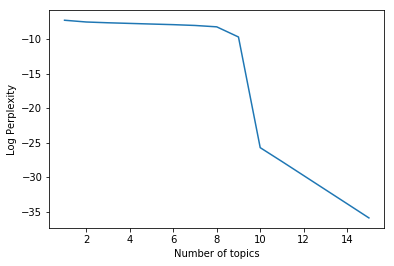

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
# matplotlib.pyplot 객체를 plt로 정의하고 import한다.
xtick=list(range(20))

plt.plot(xtick,perplexitiesT)                   
plt.xlabel('Number of topics')                  
plt.ylabel('Log Perplexity')                  

plt.show()

In [ ]:
import matplotlib.pyplot as plt     # matplotlib.pyplot 객체를 plt로 정의하고 import한다.

plt.plot(xtick,np.exp(perplexitiesT))       
plt.xlabel('Number of topics')                  
plt.ylabel('Perplexity')                

plt.show()

## LDA 모델 만들기

In [1]:
id2word = corpora.Dictionary(data_words_trigrams)
texts = data_words_trigrams
corpus = [id2word.doc2bow(text) for text in texts]

# (용어-빈도) 포맷으로 보기 위한 코드
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

lda_model = LdaModel(corpus=corpus,
id2word=id2word,
num_topics=10,
random_state=100,
update_every=1,
chunksize=100,
passes=25,
alpha='auto',
per_word_topics=True)

# Print the Keyword in the 10 topics(명사만 결과)
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

"id2word = corpora.Dictionary(data_words_trigrams)\ntexts = data_words_trigrams\ncorpus = [id2word.doc2bow(text) for text in texts]\n\n# (용어-빈도) 포맷으로 보기 위한 코드\n[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]\n\nlda_model = LdaModel(corpus=corpus,\nid2word=id2word,\nnum_topics=10,\nrandom_state=100,\nupdate_every=1,\nchunksize=100,\npasses=25,\nalpha='auto',\nper_word_topics=True)\n\n# Print the Keyword in the 10 topics(명사만 결과)\n#pprint(lda_model.print_topics())\ndoc_lda = lda_model[corpus]"